In [1]:
%load_ext autoreload
%autoreload 2

import sys
import logging
import shutil
import shutil

sys.path.append('../python/')
sys.path.append('../code/pytorch-sqrtm/')
sys.path.append('../code/')

In [2]:
from argparse import Namespace
from matplotlib import pyplot as plt

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
import seaborn as sns
import numpy as np
import os
from os import path
from metrics import ranking

from train import model_helper
from train import train_sim_aae as train_sim
# import data
import data_manual as data

import viz
import experiment as EXP
from train import model_helper
from loss import ae_losses, gan_losses
from metrics import ranking
from utils import plotter

In [3]:
torch.cuda.current_device()

0

# Adversarial Autoencoder Dev

In [4]:
#Experiment Params
DATA_CACHE = {}

IMAGE_SIZE = 64
VGG_SIZE = 4096
NBITS = 64

SEED=9
NUM_EPOCH = 50
LP_NUM_EPOCH = 50

NUM_TRAIN = 60000
NUM_DB = 60000
NUM_QUERY = 10000

In [5]:
# Default args
args = Namespace(
    dataroot = '../data/mnist-3c_isize{}_seed{}'.format(IMAGE_SIZE, SEED),
    dataset = 'mnist-3c_fc7_1',
    num_classes = 10,
    image_size = IMAGE_SIZE,
    vgg_size = VGG_SIZE,
    nc = 1,
    ngf = 64,
    ndf = 64, #size of feature maps of discriminator
    nz = NBITS,
    
    ALPHA = None,
    LAMBDA = None,
    BETA = None,
    
    useD = True,
    pretrainedD = False,
    trainD = True,
    freqD = 1,
    sampling_type = 'normal',
    d_dims = [50,50,100],
    enc_layers = [500,500,100],
    dec_layers = [100,500,500],

    
    threshold = 0,
    R = [100, 500, 1000, NUM_DB],
    
    training_dir = None,
    
    optimizer = 'Adam_0.5_0.999',
    lr = 1e-4,
    decay_type = None,
    decay_rate = None,
    beta1 = 0.5,
    beta2 = 0.999,
    
    clamp_value = None,
    clip_value = None,
    
    nprojections = 10000,

    ngpu = 1,
    workers = 2,
    batch_size = None,
    num_epochs = NUM_EPOCH,
    iters_per_stat = None,
    iters_per_internal_eval = None,
    iters_per_external_eval = None,
)

## Run on pixel data

In [6]:
args.dataset = 'mnist'
args.dataroot = '../data/mnist_isize{}_seed{}'.format(IMAGE_SIZE, SEED)

In [7]:
train_dataloader, db_dataloader, query_dataloader = EXP.get_mnist_dataloaders(args.image_size, 100, args.dataroot, workers=0)
train_x, train_y = EXP.get_numpy_data(train_dataloader)
db_x, db_y = EXP.get_numpy_data(db_dataloader)
query_x, query_y = EXP.get_numpy_data(query_dataloader)

# train_x = train_x.reshape([train_x.shape[0], -1])
# db_x = db_x.reshape([db_x.shape[0], -1])
# query_x = query_x.reshape([query_x.shape[0], -1])

print('Data range: [{}, {}]'.format(train_x.min(), train_x.max()))

/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


(60000, 1, 64, 64)
Manually loaded 60000 train examples (60000)
(60000, 1, 64, 64)
Manually loaded 60000 db examples (60000)


 12%|█▏        | 74/600 [00:00<00:00, 737.91it/s]

(10000, 1, 64, 64)
Manually loaded 10000 query examples (10000)


100%|██████████| 100/100 [00:00<00:00, 1204.02it/s]


Data range: [-1.0, 1.0]


In [13]:
def get_sim_dataloader(dataset, image_size, batch_size,
                       dataroot='data/', workers=0, data_transforms=None, type='train', shuffle=True):
    """This function is only use to create dataloader with dummy similarity matrix.
    This is to use this in combination with SSDH and DistillHash
    """
    if type == 'train':
        dataset = torch.utils.data.TensorDataset(torch.tensor(np.array(range(train_x.shape[0]))), 
                                                 torch.tensor(train_x), 
                                                 torch.tensor(np.array(range(train_x.shape[0]))), 
                                                 torch.tensor(train_y))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=shuffle, num_workers=workers)
    elif type == 'db':
        dataset = torch.utils.data.TensorDataset(torch.tensor(np.array(range(db_x.shape[0]))), 
                                                 torch.tensor(db_x), 
                                                 torch.tensor(np.array(range(db_x.shape[0]))), #dummy
                                                 torch.tensor(db_y))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                    shuffle=False, num_workers=workers)
    elif type == 'query':
        dataset = torch.utils.data.TensorDataset(torch.tensor(np.array(range(query_x.shape[0]))),
                                                 torch.tensor(query_x), 
                                                 torch.tensor(np.array(range(query_x.shape[0]))), #dummy
                                                 torch.tensor(query_y))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=workers)
    return dataloader

### Run with pixel data

../python/train/model_helper.py:24: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0)


Encoder(
  (0): Linear(in_features=4096, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=500, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=100, out_features=64, bias=True)
)
Create Adam optimizer: lr=0.0001, beta1=0.5, beta2=0.999
Decoder(
  (0): Linear(in_features=64, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=100, out_features=500, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=500, out_features=4096, bias=True)
  (7): Tanh()
)
Create Adam optimizer: lr=0.0001, beta1=0.5, beta2=0.999
Creating fresh model in ../dev/seed=9/AE_SIM/mnist/isize=64-nz=64_sign-ae=_enc=500_500_100-freqA=5-freqG=1-useD=False-adv=50_50_100-clamp=None-clip=

/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0/20][54/938][54]	Loss(A/G/D/S/T): 0.5092/0.1619/nan/nan/nan, lr 0.000100
[0/20][108/938][108]	Loss(A/G/D/S/T): 0.2186/0.1717/nan/nan/nan, lr 0.000100
[0/20][162/938][162]	Loss(A/G/D/S/T): 0.2194/0.1738/nan/nan/nan, lr 0.000100
[0/20][216/938][216]	Loss(A/G/D/S/T): 0.2177/0.1740/nan/nan/nan, lr 0.000100
[0/20][270/938][270]	Loss(A/G/D/S/T): 0.2143/0.1732/nan/nan/nan, lr 0.000100
[0/20][324/938][324]	Loss(A/G/D/S/T): 0.2142/0.1755/nan/nan/nan, lr 0.000100
[0/20][378/938][378]	Loss(A/G/D/S/T): 0.2131/0.1691/nan/nan/nan, lr 0.000100
[0/20][432/938][432]	Loss(A/G/D/S/T): 0.2116/0.1621/nan/nan/nan, lr 0.000100
[0/20][486/938][486]	Loss(A/G/D/S/T): 0.2111/0.1511/nan/nan/nan, lr 0.000100
[0/20][540/938][540]	Loss(A/G/D/S/T): 0.2120/0.1379/nan/nan/nan, lr 0.000100
[0/20][594/938][594]	Loss(A/G/D/S/T): 0.2106/0.1246/nan/nan/nan, lr 0.000100
[0/20][648/938][648]	Loss(A/G/D/S/T): 0.2127/0.1114/nan/nan/nan, lr 0.000100
[0/20][702/938][702]	Loss(A/G/D/S/T): 0.2085/0.1029/nan/nan/nan, lr 0.000100
[

[6/20][162/938][5790]	Loss(A/G/D/S/T): 0.0852/0.0217/nan/nan/nan, lr 0.000100
[6/20][216/938][5844]	Loss(A/G/D/S/T): 0.0863/0.0221/nan/nan/nan, lr 0.000100
[6/20][270/938][5898]	Loss(A/G/D/S/T): 0.0834/0.0219/nan/nan/nan, lr 0.000100
[6/20][324/938][5952]	Loss(A/G/D/S/T): 0.0844/0.0213/nan/nan/nan, lr 0.000100
[6/20][378/938][6006]	Loss(A/G/D/S/T): 0.0833/0.0218/nan/nan/nan, lr 0.000100
[6/20][432/938][6060]	Loss(A/G/D/S/T): 0.0823/0.0217/nan/nan/nan, lr 0.000100
[6/20][486/938][6114]	Loss(A/G/D/S/T): 0.0825/0.0210/nan/nan/nan, lr 0.000100
[6/20][540/938][6168]	Loss(A/G/D/S/T): 0.0808/0.0203/nan/nan/nan, lr 0.000100
[6/20][594/938][6222]	Loss(A/G/D/S/T): 0.0804/0.0210/nan/nan/nan, lr 0.000100
[6/20][648/938][6276]	Loss(A/G/D/S/T): 0.0813/0.0211/nan/nan/nan, lr 0.000100
[6/20][702/938][6330]	Loss(A/G/D/S/T): 0.0809/0.0214/nan/nan/nan, lr 0.000100
[6/20][756/938][6384]	Loss(A/G/D/S/T): 0.0814/0.0220/nan/nan/nan, lr 0.000100
[6/20][810/938][6438]	Loss(A/G/D/S/T): 0.0800/0.0223/nan/nan/nan

  0%|          | 0/157 [00:00<?, ?it/s]

Save checkpoint in: ../dev/seed=9/AE_SIM/mnist/isize=64-nz=64_sign-ae=_enc=500_500_100-freqA=5-freqG=1-useD=False-adv=50_50_100-clamp=None-clip=None-freqD=None-bsize=64-lr=0.0001-decay=None_None-optim=Adam_0.5_0.999-ALPHA=1-LAMBDA=0.1-BETA=0/saved_model/checkpoint-000010004.pt


100%|██████████| 157/157 [00:00<00:00, 349.87it/s]
/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


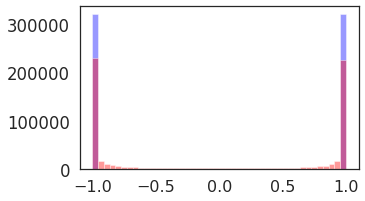

[10/20][630/938][10010]	Loss(A/G/D/S/T): 0.0573/0.0205/nan/nan/nan, lr 0.000100
[10/20][684/938][10064]	Loss(A/G/D/S/T): 0.0576/0.0209/nan/nan/nan, lr 0.000100
[10/20][738/938][10118]	Loss(A/G/D/S/T): 0.0570/0.0208/nan/nan/nan, lr 0.000100
[10/20][792/938][10172]	Loss(A/G/D/S/T): 0.0563/0.0207/nan/nan/nan, lr 0.000100
[10/20][846/938][10226]	Loss(A/G/D/S/T): 0.0571/0.0211/nan/nan/nan, lr 0.000100
[10/20][900/938][10280]	Loss(A/G/D/S/T): 0.0566/0.0210/nan/nan/nan, lr 0.000100
[11/20][18/938][10336]	Loss(A/G/D/S/T): 0.0566/0.0209/nan/nan/nan, lr 0.000100
[11/20][72/938][10390]	Loss(A/G/D/S/T): 0.0564/0.0209/nan/nan/nan, lr 0.000100
[11/20][126/938][10444]	Loss(A/G/D/S/T): 0.0570/0.0206/nan/nan/nan, lr 0.000100
[11/20][180/938][10498]	Loss(A/G/D/S/T): 0.0558/0.0208/nan/nan/nan, lr 0.000100
[11/20][234/938][10552]	Loss(A/G/D/S/T): 0.0555/0.0213/nan/nan/nan, lr 0.000100
[11/20][288/938][10606]	Loss(A/G/D/S/T): 0.0563/0.0211/nan/nan/nan, lr 0.000100
[11/20][342/938][10660]	Loss(A/G/D/S/T): 0

[16/20][576/938][15584]	Loss(A/G/D/S/T): 0.0417/0.0215/nan/nan/nan, lr 0.000100
[16/20][630/938][15638]	Loss(A/G/D/S/T): 0.0415/0.0218/nan/nan/nan, lr 0.000100
[16/20][684/938][15692]	Loss(A/G/D/S/T): 0.0413/0.0212/nan/nan/nan, lr 0.000100
[16/20][738/938][15746]	Loss(A/G/D/S/T): 0.0412/0.0211/nan/nan/nan, lr 0.000100
[16/20][792/938][15800]	Loss(A/G/D/S/T): 0.0409/0.0213/nan/nan/nan, lr 0.000100
[16/20][846/938][15854]	Loss(A/G/D/S/T): 0.0405/0.0210/nan/nan/nan, lr 0.000100
[16/20][900/938][15908]	Loss(A/G/D/S/T): 0.0409/0.0208/nan/nan/nan, lr 0.000100
[17/20][18/938][15964]	Loss(A/G/D/S/T): 0.0399/0.0208/nan/nan/nan, lr 0.000100
[17/20][72/938][16018]	Loss(A/G/D/S/T): 0.0398/0.0209/nan/nan/nan, lr 0.000100
[17/20][126/938][16072]	Loss(A/G/D/S/T): 0.0412/0.0208/nan/nan/nan, lr 0.000100
[17/20][180/938][16126]	Loss(A/G/D/S/T): 0.0401/0.0206/nan/nan/nan, lr 0.000100
[17/20][234/938][16180]	Loss(A/G/D/S/T): 0.0402/0.0209/nan/nan/nan, lr 0.000100
[17/20][288/938][16234]	Loss(A/G/D/S/T): 0

  0%|          | 0/157 [00:00<?, ?it/s]

Save checkpoint in: ../dev/seed=9/AE_SIM/mnist/isize=64-nz=64_sign-ae=_enc=500_500_100-freqA=5-freqG=1-useD=False-adv=50_50_100-clamp=None-clip=None-freqD=None-bsize=64-lr=0.0001-decay=None_None-optim=Adam_0.5_0.999-ALPHA=1-LAMBDA=0.1-BETA=0/saved_model/checkpoint-000018760.pt
[FINAL]	Loss(A/G/D/S/T): 0.0354/0.0210/nan/nan/nan


100%|██████████| 157/157 [00:00<00:00, 438.01it/s]


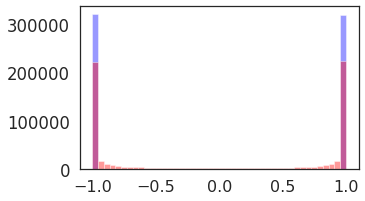

100%|██████████| 157/157 [00:00<00:00, 1165.48it/s]


[18760] EXTERNAL: 	Prec@100 0.85025, mAP@100 0.88212 (Size 10000/60000)
[18760] EXTERNAL: 	Prec@500 0.77733, mAP@500 0.83000 (Size 10000/60000)
[18760] EXTERNAL: 	Prec@1000 0.72485, mAP@1000 0.79680 (Size 10000/60000)
[18760] EXTERNAL: 	Prec@60000 0.10029, mAP@60000 0.49283 (Size 10000/60000)
FINISH TRAINING!!!


In [23]:
args.sampling_type = 'sign'

def compute_g_sliced_component_wise_wasserstein_loss(args, device, real_features, gen_features, real_output, gen_output, eval_metrics=None, netG=None):
    gen_features = torch.tanh(gen_features)
    
    """A proxy for sign sampling type"""
    return gan_losses.compute_g_sliced_component_wise_wasserstein_loss(args, device, real_features, gen_features, real_output, gen_output, 
                                                                eval_metrics=eval_metrics, netG=netG)

args.num_epochs = 20
args.enc_layers = [500, 500, 100]
args.dec_layers = [100, 500, 500]
args.ngf = None
args.ndf = None

args.ALPHA = 1 #Reconstruction loss
args.BETA = 0 #Similarity loss
args.LAMBDA = 0.1 #Adversarial G's loss

args.useD=False
args.denoising = False
args.denoising_std = None

args.freqA = 5
args.freqG = 1
args.freqD = None

args.batch_size = 64
args.lr = 0.0001

args.iters_per_stat = 50
args.iters_per_internal_eval = 10000
args.iters_per_external_eval = 99999999999 #last epoch only

args.training_dir = '../dev/seed={}/AE_SIM/'.format(SEED)
loss, metrics = train_sim.train(args, 
        EXP.create_mlp_encoder_nobn,
        EXP.create_mlp_decoder_nobn,
        None,
        get_sim_dataloader,
        ae_losses.compute_MSE_reconstruction_loss, 
        compute_g_sliced_component_wise_wasserstein_loss, None,
        run_internal_eval_func=train_sim.run_internal_eval,
        run_external_eval_func=train_sim.run_external_eval_with_original_data,
        init_training_metrics_func=train_sim.init_metrics)

In [24]:
#get the latest results
import pickle
model_dir, result_dir = train_sim.get_training_paths(args)
print(result_dir)
filename = sorted([e for e in os.listdir(result_dir) if 'evaluation' in e])[-1]
x = pickle.load(open(path.join(result_dir, filename), 'rb'))
args, db_x, db_codes, db_labels, test_x, test_codes, test_labels, _, prec, mAP = pickle.load(open(path.join(result_dir, filename), 'rb'))
db_y = np.argmax(db_labels, axis=1)
test_y = np.argmax(test_labels, axis=1)

../dev/seed=9/AE_SIM/mnist/isize=64-nz=64_sign-ae=_enc=500_500_100-freqA=5-freqG=1-useD=False-adv=50_50_100-clamp=None-clip=None-freqD=None-bsize=64-lr=0.0001-decay=None_None-optim=Adam_0.5_0.999-ALPHA=1-LAMBDA=0.1-BETA=0/results


In [25]:
tsne_b = plotter.tsne_embed(test_codes, n_iters=3000, lr=10, perplexity=50)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.275s...
[t-SNE] Computed neighbors for 10000 samples in 9.418s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.378698
[t-SNE] Computed conditional probabilities in 0.684s
[t-SNE] Iteration 50: error = 91.4520874, gradient norm = 0.0000002 (50 iterations in 1.992s)
[t-SNE] I

Number of labels: 10


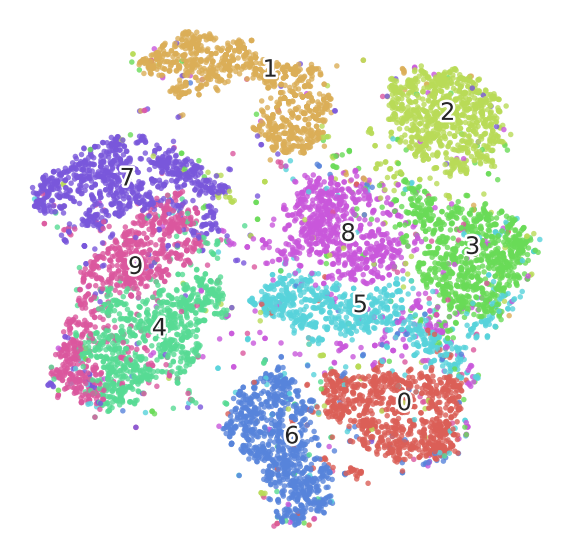

In [26]:
plotter.plot_embedding(tsne_b, test_y)

In [27]:
dist, ids = ranking.calculate_distances(db_codes, test_codes, dist_type='hamming')

3: 3 3 3 3 3 3 3 3 3 3
2: 2 2 2 2 2 2 2 2 2 2
9: 9 9 9 9 9 9 9 9 9 9
3: 3 3 3 3 3 3 3 3 3 3
6: 6 6 6 6 6 6 6 6 6 6
2: 2 2 2 2 2 2 2 2 2 2
6: 6 6 6 6 6 6 6 6 6 6
6: 6 6 6 6 6 6 6 6 6 6
3: 3 3 3 3 3 3 3 3 3 3
8: 8 8 8 8 8 8 8 8 8 8


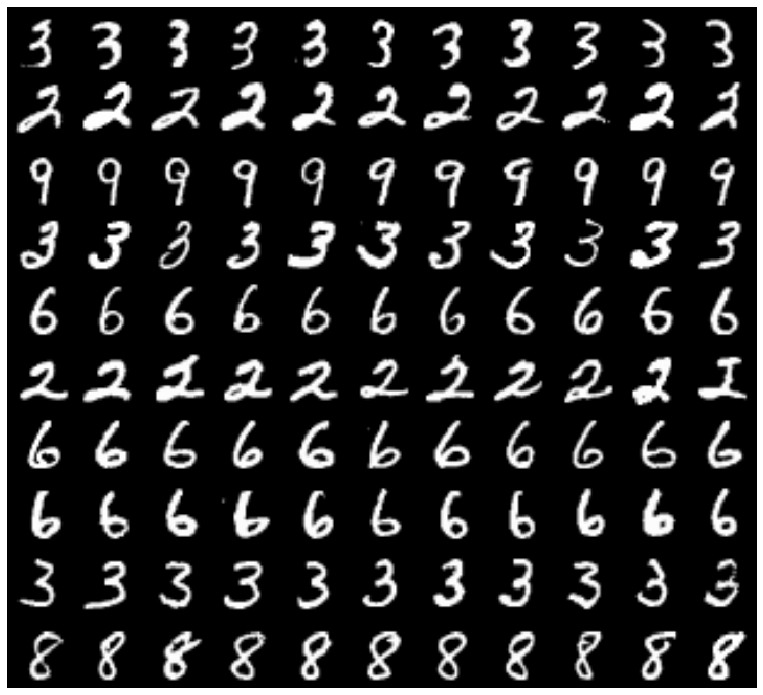

In [28]:
from torchvision import utils as vutils
label_names = [str(e) for e in range(10)]
images = []
n = 10
c = 10
for i in range(n):
    print('{}: {}'.format(label_names[test_y[i]], ' '.join([label_names[db_y[idx]] for idx in ids[0:c, i]])))

for i in range(n):
    images += [test_x[i]] + [db_x[idx] for idx in ids[0:c, i]]
images = np.array(images)
grid_images = vutils.make_grid(torch.tensor(images), padding=1, pad_value=0, normalize=True, nrow=c+1)

plt.figure(figsize=(c+1, n))
plt.axis("off")
plt.imshow(np.transpose(grid_images,(1,2,0)))
plt.tight_layout()
plt.show()

### Run without Adversarial

../python/train/model_helper.py:24: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0)


Encoder(
  (0): Linear(in_features=4096, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=500, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=100, out_features=64, bias=True)
)
Create Adam optimizer: lr=0.0001, beta1=0.5, beta2=0.999
Decoder(
  (0): Linear(in_features=64, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=100, out_features=500, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=500, out_features=4096, bias=True)
  (7): Tanh()
)
Create Adam optimizer: lr=0.0001, beta1=0.5, beta2=0.999
Creating fresh model in ../dev/seed=9/AE_SIM/mnist/isize=64-nz=64_normal-ae=_enc=500_500_100-freqA=5-freqG=0-useD=False-adv=50_50_100-clamp=None-cli

/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0/20][55/938][55]	Loss(A/G/D/S/T): 0.3873/nan/nan/nan/nan, lr 0.000100
[0/20][110/938][110]	Loss(A/G/D/S/T): 0.2190/nan/nan/nan/nan, lr 0.000100
[0/20][165/938][165]	Loss(A/G/D/S/T): 0.2178/nan/nan/nan/nan, lr 0.000100
[0/20][220/938][220]	Loss(A/G/D/S/T): 0.2156/nan/nan/nan/nan, lr 0.000100
[0/20][275/938][275]	Loss(A/G/D/S/T): 0.2170/nan/nan/nan/nan, lr 0.000100
[0/20][330/938][330]	Loss(A/G/D/S/T): 0.2142/nan/nan/nan/nan, lr 0.000100
[0/20][385/938][385]	Loss(A/G/D/S/T): 0.2154/nan/nan/nan/nan, lr 0.000100
[0/20][440/938][440]	Loss(A/G/D/S/T): 0.2144/nan/nan/nan/nan, lr 0.000100
[0/20][495/938][495]	Loss(A/G/D/S/T): 0.2140/nan/nan/nan/nan, lr 0.000100
[0/20][550/938][550]	Loss(A/G/D/S/T): 0.2134/nan/nan/nan/nan, lr 0.000100
[0/20][605/938][605]	Loss(A/G/D/S/T): 0.2120/nan/nan/nan/nan, lr 0.000100
[0/20][660/938][660]	Loss(A/G/D/S/T): 0.2112/nan/nan/nan/nan, lr 0.000100
[0/20][715/938][715]	Loss(A/G/D/S/T): 0.2113/nan/nan/nan/nan, lr 0.000100
[0/20][770/938][770]	Loss(A/G/D/S/T): 0.

[6/20][465/938][6093]	Loss(A/G/D/S/T): 0.0663/nan/nan/nan/nan, lr 0.000100
[6/20][520/938][6148]	Loss(A/G/D/S/T): 0.0675/nan/nan/nan/nan, lr 0.000100
[6/20][575/938][6203]	Loss(A/G/D/S/T): 0.0671/nan/nan/nan/nan, lr 0.000100
[6/20][630/938][6258]	Loss(A/G/D/S/T): 0.0655/nan/nan/nan/nan, lr 0.000100
[6/20][685/938][6313]	Loss(A/G/D/S/T): 0.0658/nan/nan/nan/nan, lr 0.000100
[6/20][740/938][6368]	Loss(A/G/D/S/T): 0.0660/nan/nan/nan/nan, lr 0.000100
[6/20][795/938][6423]	Loss(A/G/D/S/T): 0.0648/nan/nan/nan/nan, lr 0.000100
[6/20][850/938][6478]	Loss(A/G/D/S/T): 0.0643/nan/nan/nan/nan, lr 0.000100
[6/20][905/938][6533]	Loss(A/G/D/S/T): 0.0649/nan/nan/nan/nan, lr 0.000100
[7/20][20/938][6586]	Loss(A/G/D/S/T): 0.0627/nan/nan/nan/nan, lr 0.000100
[7/20][75/938][6641]	Loss(A/G/D/S/T): 0.0639/nan/nan/nan/nan, lr 0.000100
[7/20][130/938][6696]	Loss(A/G/D/S/T): 0.0632/nan/nan/nan/nan, lr 0.000100
[7/20][185/938][6751]	Loss(A/G/D/S/T): 0.0614/nan/nan/nan/nan, lr 0.000100
[7/20][240/938][6806]	Loss(

100%|██████████| 157/157 [00:00<00:00, 427.51it/s]


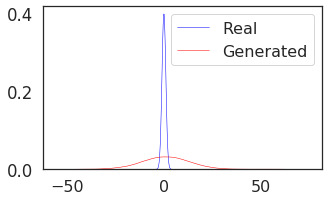

[10/20][665/938][10045]	Loss(A/G/D/S/T): 0.0488/nan/nan/nan/nan, lr 0.000100
[10/20][720/938][10100]	Loss(A/G/D/S/T): 0.0477/nan/nan/nan/nan, lr 0.000100
[10/20][775/938][10155]	Loss(A/G/D/S/T): 0.0462/nan/nan/nan/nan, lr 0.000100
[10/20][830/938][10210]	Loss(A/G/D/S/T): 0.0479/nan/nan/nan/nan, lr 0.000100
[10/20][885/938][10265]	Loss(A/G/D/S/T): 0.0459/nan/nan/nan/nan, lr 0.000100
[10/20][938/938][10318]	Loss(A/G/D/S/T): 0.0466/nan/nan/nan/nan, lr 0.000100
[11/20][55/938][10373]	Loss(A/G/D/S/T): 0.0459/nan/nan/nan/nan, lr 0.000100
[11/20][110/938][10428]	Loss(A/G/D/S/T): 0.0460/nan/nan/nan/nan, lr 0.000100
[11/20][165/938][10483]	Loss(A/G/D/S/T): 0.0454/nan/nan/nan/nan, lr 0.000100
[11/20][220/938][10538]	Loss(A/G/D/S/T): 0.0453/nan/nan/nan/nan, lr 0.000100
[11/20][275/938][10593]	Loss(A/G/D/S/T): 0.0461/nan/nan/nan/nan, lr 0.000100
[11/20][330/938][10648]	Loss(A/G/D/S/T): 0.0459/nan/nan/nan/nan, lr 0.000100
[11/20][385/938][10703]	Loss(A/G/D/S/T): 0.0448/nan/nan/nan/nan, lr 0.000100


[16/20][910/938][15918]	Loss(A/G/D/S/T): 0.0342/nan/nan/nan/nan, lr 0.000100
[17/20][25/938][15971]	Loss(A/G/D/S/T): 0.0336/nan/nan/nan/nan, lr 0.000100
[17/20][80/938][16026]	Loss(A/G/D/S/T): 0.0335/nan/nan/nan/nan, lr 0.000100
[17/20][135/938][16081]	Loss(A/G/D/S/T): 0.0324/nan/nan/nan/nan, lr 0.000100
[17/20][190/938][16136]	Loss(A/G/D/S/T): 0.0321/nan/nan/nan/nan, lr 0.000100
[17/20][245/938][16191]	Loss(A/G/D/S/T): 0.0329/nan/nan/nan/nan, lr 0.000100
[17/20][300/938][16246]	Loss(A/G/D/S/T): 0.0326/nan/nan/nan/nan, lr 0.000100
[17/20][355/938][16301]	Loss(A/G/D/S/T): 0.0323/nan/nan/nan/nan, lr 0.000100
[17/20][410/938][16356]	Loss(A/G/D/S/T): 0.0324/nan/nan/nan/nan, lr 0.000100
[17/20][465/938][16411]	Loss(A/G/D/S/T): 0.0321/nan/nan/nan/nan, lr 0.000100
[17/20][520/938][16466]	Loss(A/G/D/S/T): 0.0324/nan/nan/nan/nan, lr 0.000100
[17/20][575/938][16521]	Loss(A/G/D/S/T): 0.0321/nan/nan/nan/nan, lr 0.000100
[17/20][630/938][16576]	Loss(A/G/D/S/T): 0.0323/nan/nan/nan/nan, lr 0.000100
[

 29%|██▉       | 46/157 [00:00<00:00, 452.59it/s]

Save checkpoint in: ../dev/seed=9/AE_SIM/mnist/isize=64-nz=64_normal-ae=_enc=500_500_100-freqA=5-freqG=0-useD=False-adv=50_50_100-clamp=None-clip=None-freqD=None-bsize=64-lr=0.0001-decay=None_None-optim=Adam_0.5_0.999-ALPHA=1-LAMBDA=0-BETA=0/saved_model/checkpoint-000018760.pt
[FINAL]	Loss(A/G/D/S/T): 0.0291/nan/nan/nan/nan


100%|██████████| 157/157 [00:00<00:00, 452.68it/s]


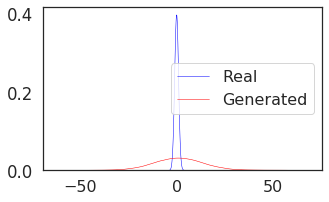

100%|██████████| 157/157 [00:00<00:00, 1161.59it/s]


[18760] EXTERNAL: 	Prec@100 0.83980, mAP@100 0.87258 (Size 10000/60000)
[18760] EXTERNAL: 	Prec@500 0.76375, mAP@500 0.81807 (Size 10000/60000)
[18760] EXTERNAL: 	Prec@1000 0.70985, mAP@1000 0.78366 (Size 10000/60000)
[18760] EXTERNAL: 	Prec@60000 0.10029, mAP@60000 0.46590 (Size 10000/60000)
FINISH TRAINING!!!


In [29]:
args.sampling_type = 'normal'

args.num_epochs = 20
args.enc_layers = [500, 500, 100]
args.dec_layers = [100, 500, 500]
args.ngf = None
args.ndf = None

args.ALPHA = 1 #Reconstruction loss
args.BETA = 0 #Similarity loss
args.LAMBDA = 0 #Adversarial G's loss

args.useD=False
args.denoising = False
args.denoising_std = None

args.freqA = 5
args.freqG = 0
args.freqD = None

args.batch_size = 64
args.lr = 0.0001

args.iters_per_stat = 50
args.iters_per_internal_eval = 10000
args.iters_per_external_eval = 99999999999 #last epoch only

args.training_dir = '../dev/seed={}/AE_SIM/'.format(SEED)
loss, metrics = train_sim.train(args, 
        EXP.create_mlp_encoder_nobn,
        EXP.create_mlp_decoder_nobn,
        None,
        get_sim_dataloader,
        ae_losses.compute_MSE_reconstruction_loss, 
        gan_losses.compute_g_sliced_component_wise_wasserstein_loss, None,
        run_internal_eval_func=train_sim.run_internal_eval,
        run_external_eval_func=train_sim.run_external_eval_with_original_data,
        init_training_metrics_func=train_sim.init_metrics)

### SSDH

In [8]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

In [9]:
if train_x.shape[0] > 10000: #sample, heavy to keep sim matrix in memory
    ssdh_train_x = train_x.reshape([train_x.shape[0], -1])
    ssdh_train_x, _, ssdh_train_y, _ = train_test_split(ssdh_train_x, train_y, train_size=10000, stratify=train_y)
ssdh_db_x = db_x.reshape([db_x.shape[0], -1])
ssdh_query_x = query_x.reshape([query_x.shape[0], -1])
xmin, xmax = train_x.min(axis=0), train_x.max(axis=0) 
xmean = train_x.mean(axis=0)

In [10]:
from datetime import datetime
from sklearn.metrics import pairwise_distances_chunked

n_train = ssdh_train_y.shape[0]
start = datetime.now()
distances = np.zeros((n_train, n_train), np.float32)

D_chunk = pairwise_distances_chunked(ssdh_train_x, metric='cosine')

pbar = tqdm(total=train_x.shape[0])
i = 0
for chunk in D_chunk:
    distances[i:i+chunk.shape[0], :] = chunk
    pbar.update(chunk.shape[0])
    i += chunk.shape[0]
pbar.close()
end = datetime.now()
print('Duration: {} seconds'.format((end-start).total_seconds()))

/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Duration: 2.206856 seconds


In [11]:
from scipy.stats import norm

print('Calculating sqquareform...')
start = -0.00000001
margin = 1.0/100
num = np.zeros(100)
max_num = 0.0
max_value = 0.0
orig_distances = distances

# Histogram distribution 
for i in tqdm(range(100)):
    end = start+margin
    temp_matrix = (distances>start)&(distances<end)
    num[i] = np.sum(temp_matrix)
    if num[i]>max_num:
        max_num = num[i]
        max_value = start
    start = end
distances = distances.reshape(-1,1)
left = []
right = []
for i in tqdm(range(distances.shape[0])):
    if distances[i] <= max_value:
        left.append(distances[i])
    else:
        right.append(distances[i])
left = np.array(left)
right = np.array(right)
fake_right = 2*max_value - left 
fake_left = 2*max_value - right 
left_all = np.concatenate([left, fake_right])
right_all = np.concatenate([fake_left, right])

# Gaussian distribution approximation
l_mean, l_std = norm.fit(left_all)
r_mean, r_std = norm.fit(right_all)

# Obtain fake labels
S1 = ((orig_distances < l_mean-2*l_std))*1.0
S2 = ((orig_distances > r_mean+2*r_std))*(-1.0)
S = S1 + S2

Calculating sqquareform...


/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/home/khoa/miniconda3/envs/hashing/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [13]:
def get_ssdh_sim_dataloader(dataset, image_size, batch_size,
                       dataroot='data/', workers=0, data_transforms=None, type='train', shuffle=True):
    if type == 'train':
        dataset = torch.utils.data.TensorDataset(torch.tensor(np.array(range(ssdh_train_x.shape[0]))), 
                                                 torch.tensor(ssdh_train_x), torch.tensor(S), torch.tensor(ssdh_train_y))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=shuffle, num_workers=workers)
    elif type == 'db':
        dataset = torch.utils.data.TensorDataset(torch.tensor(np.array(range(ssdh_db_x.shape[0]))), 
                                                 torch.tensor(ssdh_db_x), torch.tensor(np.zeros(ssdh_db_x.shape[0])), #dummy
                                                 torch.tensor(db_y))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                    shuffle=False, num_workers=workers)
    elif type == 'query':
        dataset = torch.utils.data.TensorDataset(torch.tensor(np.array(range(ssdh_query_x.shape[0]))),
                                                 torch.tensor(ssdh_query_x), torch.tensor(np.zeros(ssdh_query_x.shape[0])), #dummy
                                                 torch.tensor(query_y))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=workers)
    return dataloader

In [ ]:
args.sampling_type = 'normal'

args.num_epochs = 40
args.enc_layers = [500, 500, 100]
args.dec_layers = [100, 500, 500]
args.ngf = None
args.ndf = None

args.ALPHA = 0 #Reconstruction loss
args.BETA = 1 #Similarity loss
args.LAMBDA = 0 #Adversarial G's loss

args.useD=False
args.denoising = False
args.denoising_std = None

args.freqA = 1
args.freqG = 0
args.freqD = None

args.batch_size = 64
args.lr = 0.0001

args.iters_per_stat = 50
args.iters_per_internal_eval = 10000
args.iters_per_external_eval = 99999999999 #last epoch only

args.training_dir = '../dev/seed={}/AE_SIM/'.format(SEED)
loss, metrics = train_sim.train(args, 
        EXP.create_mlp_encoder_nobn,
        EXP.create_mlp_decoder_nobn,
        None,
        get_ssdh_sim_dataloader,
        ae_losses.compute_MSE_reconstruction_loss, 
        gan_losses.compute_g_sliced_component_wise_wasserstein_loss, None,
        run_internal_eval_func=train_sim.run_internal_eval,
        run_external_eval_func=train_sim.run_external_eval_with_original_data,
        init_training_metrics_func=train_sim.init_metrics)

# END